In [1]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34817 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34817/status,
Dashboard: /proxy/34817/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35881,Workers: 4
Dashboard: /proxy/34817/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:37317,Total threads: 4
Dashboard: /proxy/36967/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:41933,


# Check for nans

In [2]:
data = xr.open_dataset('ERA5-monthly_averaged.nc')

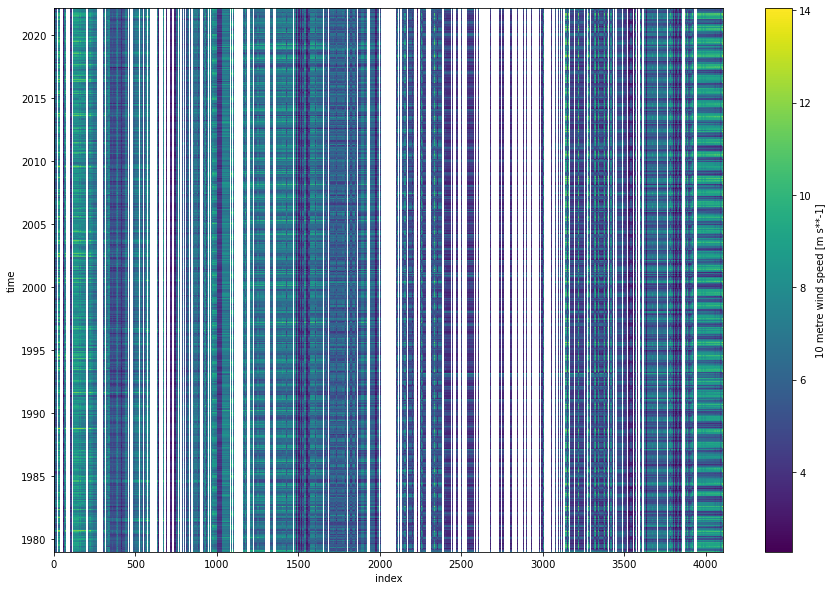

In [27]:
# The plot shows that at some locations there is no data (nan for all timesteps)
data['wind'].plot(size=10)

In [31]:
# For example, here:
data['wind'].isel(index=2050)

<xarray.DataArray 'wind' (time: 518)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    index    int64 2050
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
Attributes:
    units:      m s**-1
    long_name:  10 metre wind speed

In [33]:
# Longitude of said nan filled point
data['long'].isel(index=2050)

<xarray.DataArray 'long' ()>
array(123.583107)
Coordinates:
    index    int64 2050

In [34]:
# Latitude of said nan filled point
data['lat'].isel(index=2050)

<xarray.DataArray 'lat' ()>
array(-17.509639)
Coordinates:
    index    int64 2050

In [37]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [38]:
# Lets open the original data and look for that point
wind = xr.open_mfdataset(np.sort(glob.glob(path_era5_monthly+'wind/**/*.nc')))

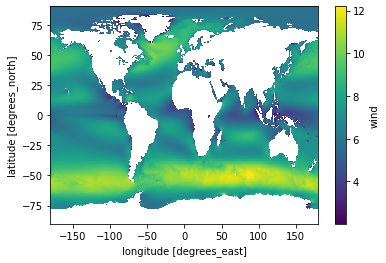

In [46]:
wind['wind'].mean('time').plot()

All right, wind seems to be masked for land! We have to calculate it using u10 and v10 then (now added to the general notebook)

# Caculate wind from u10 and v10

In [50]:
# These are the directory names, concatonated on the path above
variables = ['10u', '10v']

Open concatenated datasets:

In [51]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')

Opening: 10u
Opened
Opening: 10v
Opened


In [52]:
data['wind'] = np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')

In [53]:
data['wind']

<xarray.DataArray 'wind' (time: 518, latitude: 721, longitude: 1440)>
dask.array<sqrt, shape=(518, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01

In [54]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

Get nearest point in ERA5 for all variables:

In [55]:
for v in ['wind']:
    ext = data[v].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
    extracted_data[v] = xr.DataArray(ext, 
                                     dims = {'index', 'time'}, 
                                     coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

In [56]:
extracted_data

<xarray.Dataset>
Dimensions:  (index: 4109, time: 518)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 4102 4103 4104 4105 4106 4107 4108
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
Data variables:
    ulm_ID   (index) int64 840 1282 75593 75594 ... 85144 85145 85146 85147
    long     (index) float64 158.7 158.9 147.0 147.0 ... 145.2 145.3 145.5 145.5
    lat      (index) float64 -55.11 -54.63 -43.86 ... -14.65 -14.86 -14.75
    wind     (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>

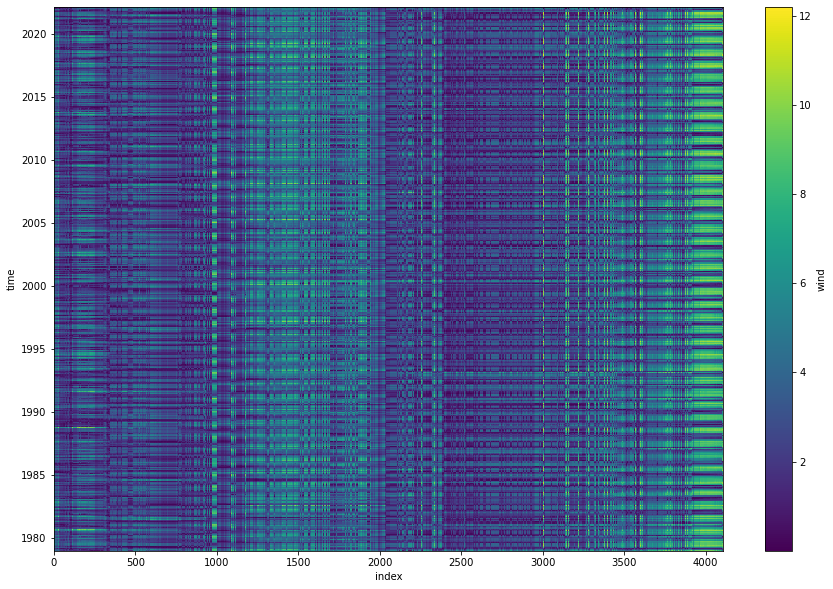

In [57]:
extracted_data['wind'].plot(size=10)

In [58]:
old_ncfile = xr.open_dataset('ERA5-monthly_averaged.nc')

In [59]:
old_ncfile = old_ncfile.drop('wind')

In [60]:
old_ncfile['wind'] = extracted_data['wind']

# Make <0 rain ==0

In [61]:
old_ncfile['mtpr'] = xr.where(old_ncfile['mtpr']<0, 0, old_ncfile['mtpr'])

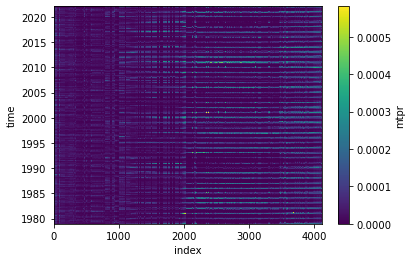

In [62]:
old_ncfile['mtpr'].plot()

# Calculate monthly Tmax, Tmin, RH

In [63]:
data_daily = xr.open_dataset('ERA5-daily_averaged.nc')

In [64]:
data_daily

<xarray.Dataset>
Dimensions:  (index: 4109, time: 15765)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 4102 4103 4104 4105 4106 4107 4108
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-02-28
Data variables:
    ulm_ID   (index) int64 ...
    long     (index) float64 ...
    lat      (index) float64 ...
    mtpr     (time, index) float32 ...
    mn2t     (time, index) float32 ...
    mx2t     (time, index) float32 ...
    aluvp    (time, index) float32 ...
    2t       (time, index) float32 ...
    2d       (time, index) float32 ...
    sp       (time, index) float32 ...
    rh       (time, index) float32 ...

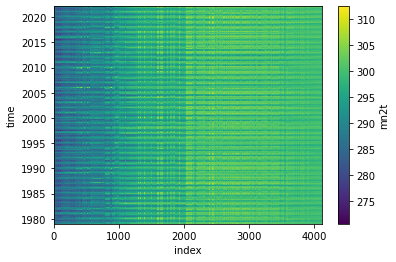

In [75]:
data_daily['mn2t'].plot()

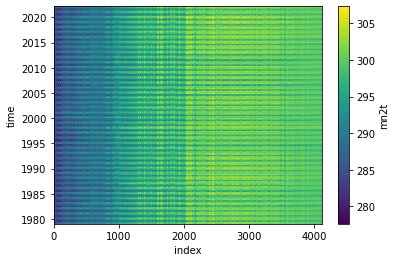

In [78]:
data_daily['mn2t'].resample(time = '1M').mean('time').plot()

In [83]:
old_ncfile['mn2t'] = xr.DataArray(data_daily['mn2t'].resample(time = '1M').mean('time'), 
                                  dims = {'index', 'time'}, 
                                  coords = {'index':extracted_data['index'], 'time':data[v]['time']})

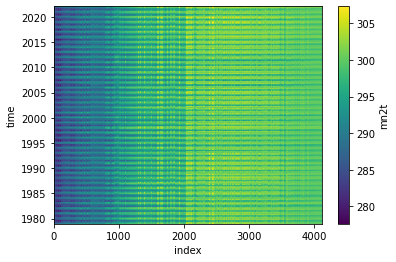

In [84]:
old_ncfile['mn2t'].plot()

# Add land mask
We can use the wind land mask

In [71]:
# Add land mask. For this, we open a variable that we now is masked. In this case, wind
# Open just one file, we don't care about time variations
mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/10v/1979/10v_era5_moda_sfc_19790101-19790131.nc')

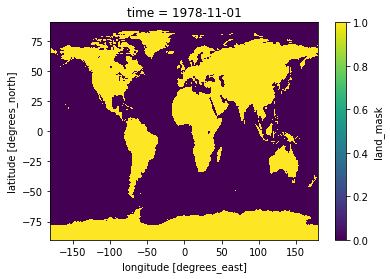

In [66]:
mask = wind['wind'].isel(time=0)

mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [67]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
old_ncfile['land_mask'] = xr.DataArray(ext, 
                                 dims = {'index'}, 
                                 coords = {'index':extracted_data['index']})

In [68]:
old_ncfile

<xarray.Dataset>
Dimensions:    (time: 518, index: 4109)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
  * index      (index) int64 0 1 2 3 4 5 6 ... 4103 4104 4105 4106 4107 4108
Data variables: (12/13)
    ulm_ID     (index) int64 ...
    long       (index) float64 ...
    lat        (index) float64 ...
    2t         (time, index) float32 ...
    mtpr       (time, index) float32 4.78e-05 5.008e-05 ... 8.166e-05 8.166e-05
    msdrswrf   (time, index) float32 ...
    ...         ...
    sns        (time, index) float32 ...
    wind       (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    mn2t       (time, index) float32 nan nan nan nan nan ... nan nan nan nan nan
    mx2t       (time, index) float32 nan nan nan nan nan ... nan nan nan nan nan
    rh         (time, index) float32 nan nan nan nan nan ... nan nan nan nan nan
    land_mask  (index) int64 dask.array<chunksize=(4109,), meta=np.ndarray>

In [69]:
old_ncfile.to_netcdf('ERA5-monthly_averaged_new.nc')